In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import numpy as np

In [15]:
from scipy.stats import binom

In [29]:
fico_df = pd.read_csv('Task 3 and 4_Loan_Data.csv')

In [30]:
fico_df.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [31]:
# initialize 5 buckets first
num_buckets = 3
fico_df['bucket'] = pd.cut(fico_df['fico_score'], bins = num_buckets, labels = False)

In [32]:
# initialize the bucket boundaries

In [33]:
def calculate_log_likelihood(data):
    log_likelihood = 0
    for b in range(num_buckets):
        bucket_data = fico_df[fico_df['bucket']==b]
        if not bucket_data.empty:
            ni = len(bucket_data)
            ki= bucket_data['default'].sum()
            pi = ki/ni if ni>0 else 0
            log_likelihood += binom.logpmf(ki, ni, pi)
    return log_likelihood


In [34]:
initial_log_likelihood = calculate_log_likelihood(fico_df)

In [35]:
print(f"Initial log_likelihood: {initial_log_likelihood}")

Initial log_likelihood: -11.003065292071632


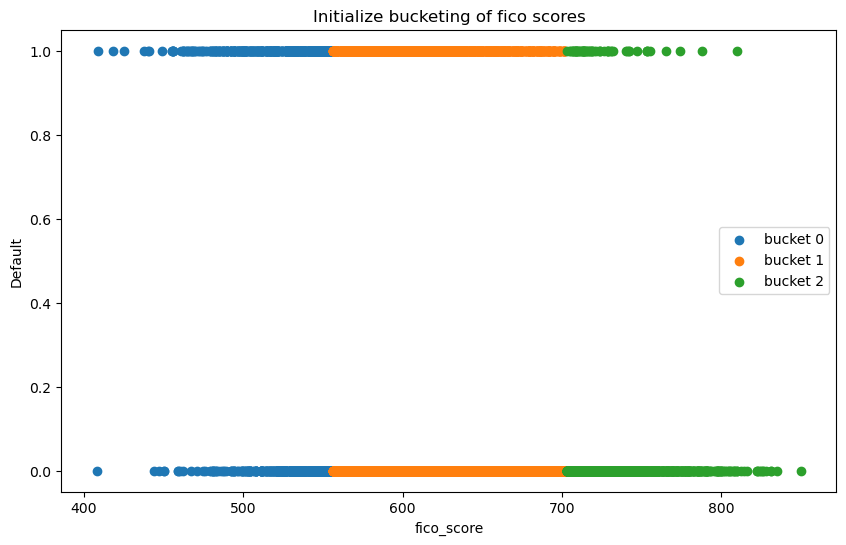

In [36]:
# plotting the initial bucketing

plt.figure(figsize = (10, 6))
for b in range(num_buckets):
    bucket_data = fico_df[fico_df['bucket']==b]
    plt.scatter(bucket_data['fico_score'], bucket_data['default'], label = f"bucket {b}", marker = 'o')
plt.xlabel('fico_score')
plt.ylabel('Default')
plt.legend()
plt.title('Initialize bucketing of fico scores')
plt.show()

    

In [37]:
# Bucket optimization

In [38]:
def optimize_buckets(data, num_buckets, max_iter = 100):
    boundaries = np.linspace(fico_df['fico_score'].min(),fico_df['fico_score'].max(), num_buckets+1 )
    best_likelihood = calculate_log_likelihood(data)
    improved = True
    iter = 0
    while improved and iter<max_iter:
        improved = False
        for i in range(1, len(boundaries)-1):
            original_bound = boundaries[i]
            for shift in [-10, 10]:
                boundaries += shift
                fico_df['bucket'] = pd.cut(fico_df['fico_score'], bins = boundaries, labels = False, include_lowest = True )
                new_likelihood = calculate_log_likelihood(data)
                if new_likelihood > best_likelihood:
                    best_likelihood = new_likelihood
                    improved = True
                else:
                    boundaries[i] = original_bound
        iter+=1
        print(f"Iteration{iter}, log_likelihood: {best_likelihood}")
    return boundaries

In [39]:
final_boundaries = optimize_buckets(fico_df, num_buckets)

Iteration1, log_likelihood: -10.83263386556164
Iteration2, log_likelihood: -10.556590926529623
Iteration3, log_likelihood: -10.262599595572512
Iteration4, log_likelihood: -10.084655430092736
Iteration5, log_likelihood: -10.024243183426666
Iteration6, log_likelihood: -9.69517824659931
Iteration7, log_likelihood: -9.557973241290577
Iteration8, log_likelihood: -9.369442358212641
Iteration9, log_likelihood: -9.065056152733305
Iteration10, log_likelihood: -9.05767275124986
Iteration11, log_likelihood: -8.076178920129678
Iteration12, log_likelihood: -8.076178920129678


In [40]:
fico_df['bucket'] = pd.cut(fico_df['fico_score'], bins = final_boundaries, labels = False, include_lowest = True)
final_boundaries

array([408.        , 555.33333333, 812.66666667, 850.        ])

In [49]:
def optimize_bucket_count(data, min_buckets, max_buckets):
    best_overall_likelihood = float('-inf')
    best_bucket_count = min_buckets
    best_boundaries = None
    for num_buckets in range(min_buckets, max_buckets+1):
        print(f"Testing {num_buckets} buckets...")
        boundaries = np.linspace(fico_df['fico_score'].min(),fico_df['fico_score'].max(), num_buckets+1 )
        data['bucket'] = pd.cut(data['fico_score'], bins = boundaries, labels = False, include_lowest = True)
        final_likelihood = calculate_log_likelihood(data)
        
        print(f"Boundaries for {num_buckets} buckets: {boundaries}")
        print(f"Log_likelihood for {num_buckets} buckets: {final_likelihood}")
        
        if final_likelihood> best_overall_likelihood:
            best_overall_likelihood = final_likelihood
            best_bucket_count = num_buckets
            best_boundaries = boundaries
    return best_bucket_count, best_boundaries, best_overall_likelihood

In [50]:
best_count, best_boundaries, best_likelihood = optimize_bucket_count(fico_df, 4, 10)
print(f"Best number of buckets: {best_count}, with log_likelihood: {best_likelihood}")

Testing 4 buckets...
Boundaries for 4 buckets: [408.  518.5 629.  739.5 850. ]
Log_likelihood for 4 buckets: -11.270920800040727
Testing 5 buckets...
Boundaries for 5 buckets: [408.  496.4 584.8 673.2 761.6 850. ]
Log_likelihood for 5 buckets: -10.712553721958201
Testing 6 buckets...
Boundaries for 6 buckets: [408.         481.66666667 555.33333333 629.         702.66666667
 776.33333333 850.        ]
Log_likelihood for 6 buckets: -9.95862240258636
Testing 7 buckets...
Boundaries for 7 buckets: [408.         471.14285714 534.28571429 597.42857143 660.57142857
 723.71428571 786.85714286 850.        ]
Log_likelihood for 7 buckets: -9.195682356411078
Testing 8 buckets...
Boundaries for 8 buckets: [408.   463.25 518.5  573.75 629.   684.25 739.5  794.75 850.  ]
Log_likelihood for 8 buckets: -8.50181492341184
Testing 9 buckets...
Boundaries for 9 buckets: [408.         457.11111111 506.22222222 555.33333333 604.44444444
 653.55555556 702.66666667 751.77777778 800.88888889 850.        ]
Log_

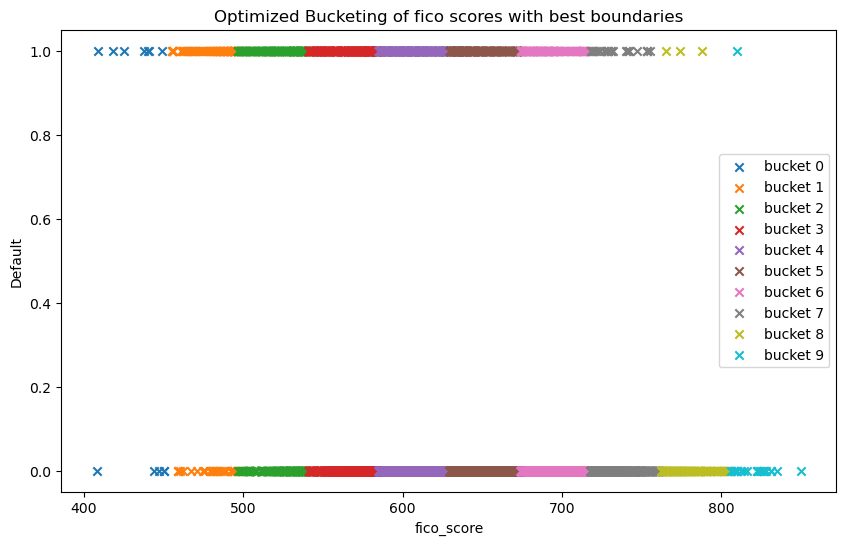

In [54]:
# plotting the final bucketing

num_buckets = best_count
final_boundaries = best_boundaries

#update the data frame with the optimal bucket assignment
fico_df['bucket'] = pd.cut(fico_df['fico_score'], bins= final_boundaries, labels = False, include_lowest = True)

plt.figure(figsize= (10,6))
for b in range(num_buckets):
    bucket_data = fico_df[fico_df['bucket'] ==b]
    plt.scatter(bucket_data['fico_score'], bucket_data['default'], label = f'bucket {b}', marker = 'x')
plt.xlabel('fico_score')
plt.ylabel('Default')
plt.legend()
plt.title('Optimized Bucketing of fico scores with best boundaries')
plt.show()